In [1]:
# Import basic libraries
import dask.distributed as dsk
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# Plotting libraries
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cmocean as cm
import matplotlib.pyplot as plt

# Start client
clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41467,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:46087,Total threads: 2
Dashboard: /proxy/39803/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:44767,


# Monthly averaged data

In [2]:
path_era5_monthly = '/g/data/rt52/era5/single-levels/monthly-averaged/'

In [3]:
variables = ['2t', 'mtpr', 'wind', 'msdrswrf', 'aluvp']

Open concatenated datasets:

In [4]:
data = {}
for v in variables:
    print('Opening: '+v)
    listv = np.sort(glob.glob(path_era5_monthly+v+'/**/*.nc'))
    data[v] = xr.open_mfdataset(listv)
    print('Opened')
data['sns'] = (1 - data['aluvp']['aluvp'])*data['msdrswrf']['msdrswrf']

Opening: 2t
Opened
Opening: mtpr
Opened
Opening: wind
Opened
Opening: msdrswrf
Opened
Opening: aluvp
Opened


Extract the locations of interest and put them in a dataarray:

In [29]:
df = pd.read_csv('/g/data/e14/jn8053/andy-pitman/islands_AUS_export.csv')
locations = df.to_xarray()
extracted_data = xr.Dataset(data_vars = {'ulm_ID':locations['ulm_ID'],'long':locations['long'],'lat':locations['lat']})

Get nearest point in ERA5 for all variables:

In [30]:
for v in variables:
    for var_name in data[v].data_vars:
        ext = data[v][var_name].sel(longitude = extracted_data['long'], latitude = extracted_data['lat'], method = 'nearest')
        extracted_data[v] = xr.DataArray(ext, 
                                         dims = {'index', 'time'}, 
                                         coords = {'index':extracted_data['index'], 'time':data[v]['time']}).rename(v)
# Add sns
ext = data['sns'].sel(longitude = extracted_data['long'], latitude = extracted_data['lat'], method = 'nearest')
extracted_data['sns'] = xr.DataArray(ext, 
                                     dims = {'index', 'time'}, 
                                     coords = {'index':extracted_data['index'], 'time':data[v]['time']}).rename('sns')

In [32]:
extracted_data.to_netcdf('ERA5-monthly_averaged.nc')

## Make time-mean plots:

In [51]:
data = xr.open_dataset('ERA5-monthly_averaged.nc')

In [94]:
# Make figure instance with Aus. maps
def australia_plot():
    # Projection
    albo = ccrs.AlbersEqualArea(central_latitude=0,
                                false_easting=0, 
                                false_northing=0, 
                                central_longitude=132, 
                                standard_parallels=(-18, -36))
    fig = plt.figure(figsize=(20,10))
    axs = [fig.add_subplot(231, projection=albo),
           fig.add_subplot(232, projection=albo),
           fig.add_subplot(233, projection=albo),
           fig.add_subplot(234, projection=albo),
           fig.add_subplot(235, projection=albo),
           fig.add_subplot(236, projection=albo)]
    for ax in axs:
        ax.set_extent([112, 156, -44, -7])
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                       edgecolor = 'black', facecolor = 'gainsboro'), zorder = 0)
        ax.gridlines()
    return fig, axs

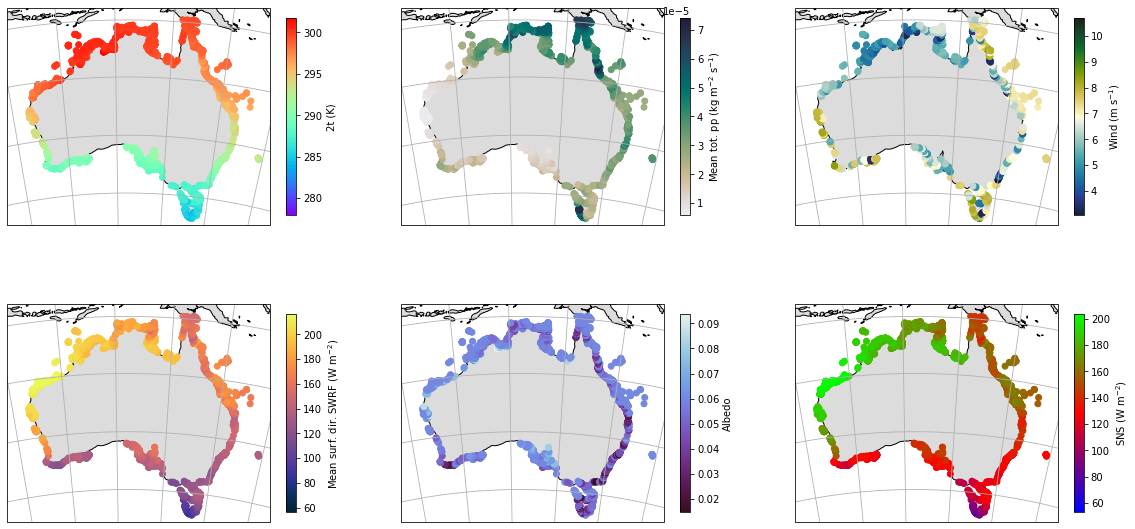

In [95]:
fig, axs = australia_plot();
p = axs[0].scatter(data['long'], data['lat'], c = data['2t'].mean('time'), cmap = 'rainbow',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[0], shrink = .8).set_label('2t (K)')
p = axs[1].scatter(data['long'], data['lat'], c = data['mtpr'].mean('time'), cmap = cm.cm.rain,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[1], shrink = .8).set_label('Mean tot. pp (kg m$^{-2}$ s$^{-1}$)')
p = axs[2].scatter(data['long'], data['lat'], c = data['wind'].mean('time'), cmap = cm.cm.delta,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[2], shrink = .8).set_label('Wind (m s$^{-1}$)')
p = axs[3].scatter(data['long'], data['lat'], c = data['msdrswrf'].mean('time'), cmap = cm.cm.thermal,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[3], shrink = .8).set_label('Mean surf. dir. SWRF (W m$^{-2}$)')
p = axs[4].scatter(data['long'], data['lat'], c = data['aluvp'].mean('time'), cmap = cm.cm.dense_r,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[4], shrink = .8).set_label('Albedo')
p = axs[5].scatter(data['long'], data['lat'], c = data['sns'].mean('time'), cmap = 'brg',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[5], shrink = .8).set_label('SNS (W m$^{-2}$)')

## Random time series

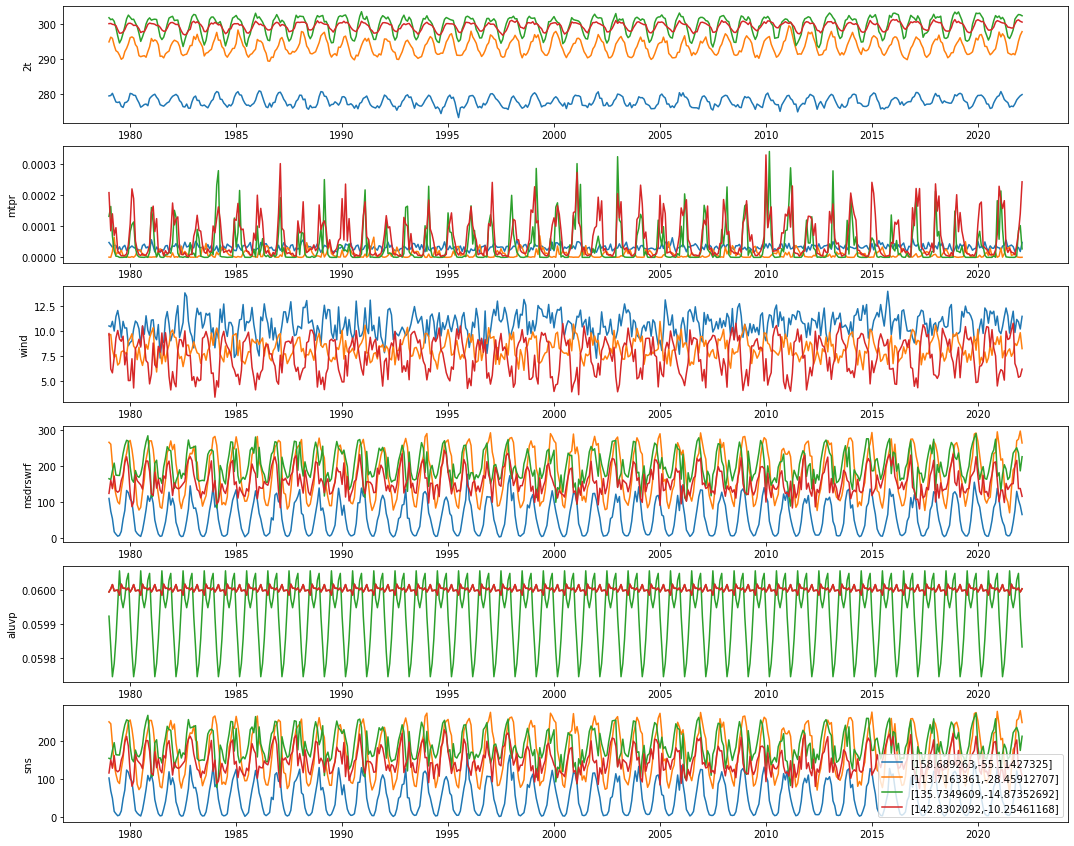

In [86]:
fig = plt.figure(figsize=(18,15))
axs = [fig.add_subplot(611),
       fig.add_subplot(612),
       fig.add_subplot(613),
       fig.add_subplot(614),
       fig.add_subplot(615),
       fig.add_subplot(616)]
n = 0
for v in variables+['sns']:
    for i in [0, 1000, 3000, 4000]:
        label = '['+str(data['long'].isel(index=i).item())+','+str(data['lat'].isel(index=i).item())+']'
        axs[n].plot(data['time'], data[v].isel(index = i), label = label)
        axs[n].set_ylabel(v)
    n += 1
plt.legend()

# Daily averaged data

In [119]:
df = pd.read_csv('/g/data/e14/jn8053/andy-pitman/islands_AUS_export.csv')
locations = df.to_xarray()
extracted_data = xr.Dataset(data_vars = {'ulm_ID':locations['ulm_ID'],'long':locations['long'],'lat':locations['lat']})

In [116]:
# Avoid loading globally, and resample from hourly to daily
def preprocessing(ds):
    ds = ds.sel(longitude = slice(112, 156), latitude = slice(-7, -44))
    ds = ds.resample(time = '1D').mean('time')
    return ds

In [108]:
path_era5_daily = '/g/data/rt52/era5/single-levels/reanalysis/'

In [109]:
variables = ['mtpr', 'mn2t', 'mx2t', 'aluvp', '2t', '2d', 'sp']

Open concatenated datasets:

In [121]:
data = {}
for v in variables:
    print('Opening: '+v)
    listv = np.sort(glob.glob(path_era5_daily+v+'/**/*.nc'))
    data[v] = xr.open_mfdataset(listv, preprocess = preprocessing)
    print('Opened')

Opening: mtpr
Opened
Opening: mn2t
Opened
Opening: mx2t
Opened
Opening: aluvp
Opened
Opening: 2t
Opened
Opening: 2d
Opened
Opening: sp
Opened


In [ ]:
for v in variables:
    for var_name in data[v].data_vars:
        ext = data[v][var_name].sel(longitude = extracted_data['long'], latitude = extracted_data['lat'], method = 'nearest')
        extracted_data[v] = xr.DataArray(ext, 
                                         dims = {'index', 'time'}, 
                                         coords = {'index':extracted_data['index'], 'time':data[v]['time']}).rename(v)

Saving takes time because it has to load into memory:

In [ ]:
extracted_data.to_netcdf('ERA5-daily_averaged.nc')

## Make time-mean plots:

In [125]:
data = xr.open_dataset('ERA5-daily_averaged.nc')

### Add relative humidity

$$RH = 100exp(\frac{cb(DP-T)}{(c+T)(c+DP)})$$

with b = 17.625 and c = 243.04

In [143]:
data['rh'] = xr.DataArray(100*np.exp(243.04*17.625*(data['2d'] - data['2t']) / ((243.04+data['2t'])*(243.04+data['2d']))), 
                          dims = {'index', 'time'}, 
                          coords = {'index':extracted_data['index'], 'time':data[v]['time']}).rename('rh')

In [144]:
data.to_netcdf('ERA5-daily_averaged.nc')

In [145]:
def australia_plot():
    # Projection
    albo = ccrs.AlbersEqualArea(central_latitude=0,
                                false_easting=0, 
                                false_northing=0, 
                                central_longitude=132, 
                                standard_parallels=(-18, -36))
    fig = plt.figure(figsize=(20,8))
    axs = [fig.add_subplot(241, projection=albo),
           fig.add_subplot(242, projection=albo),
           fig.add_subplot(243, projection=albo),
           fig.add_subplot(244, projection=albo),
           fig.add_subplot(245, projection=albo),
           fig.add_subplot(246, projection=albo),
           fig.add_subplot(247, projection=albo),
           fig.add_subplot(248, projection=albo)]
    for ax in axs:
        ax.set_extent([112, 156, -44, -7])
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                       edgecolor = 'black', facecolor = 'gainsboro'), zorder = 0)
        ax.gridlines()
    return fig, axs

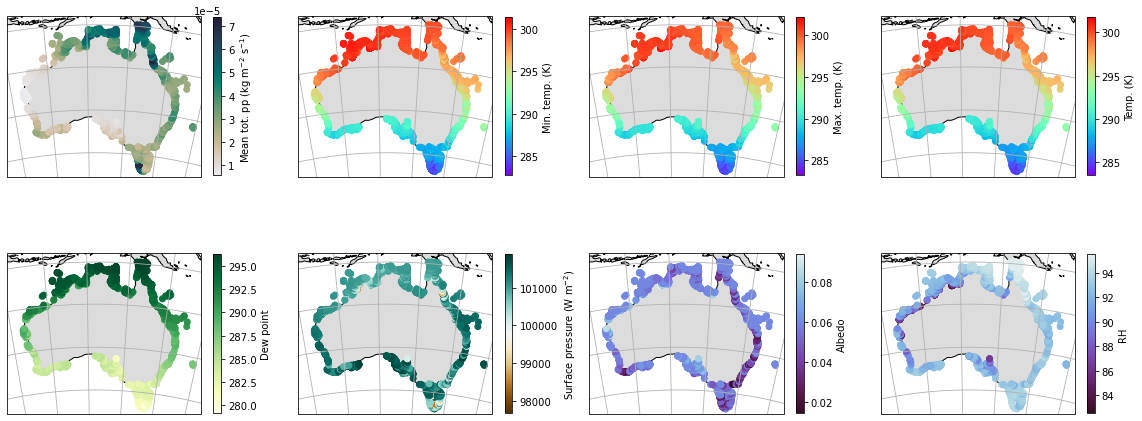

In [147]:
fig, axs = australia_plot();
p = axs[0].scatter(data['long'], data['lat'], c = data['mtpr'].mean('time'), cmap = cm.cm.rain,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[0], shrink = .8).set_label('Mean tot. pp (kg m$^{-2}$ s$^{-1}$)')
p = axs[1].scatter(data['long'], data['lat'], c = data['mn2t'].mean('time'), cmap = 'rainbow',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[1], shrink = .8).set_label('Min. temp. (K)')
p = axs[2].scatter(data['long'], data['lat'], c = data['mx2t'].mean('time'), cmap = 'rainbow',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[2], shrink = .8).set_label('Max. temp. (K)')
p = axs[3].scatter(data['long'], data['lat'], c = data['2t'].mean('time'), cmap = 'rainbow',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[3], shrink = .8).set_label('Temp. (K)')
p = axs[4].scatter(data['long'], data['lat'], c = data['2d'].mean('time'), cmap = 'YlGn',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[4], shrink = .8).set_label('Dew point')
p = axs[5].scatter(data['long'], data['lat'], c = data['sp'].mean('time'), cmap = 'BrBG',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[5], shrink = .8).set_label('Surface pressure (W m$^{-2}$)')
p = axs[6].scatter(data['long'], data['lat'], c = data['aluvp'].mean('time'), cmap = cm.cm.dense_r,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[6], shrink = .8).set_label('Albedo')
p = axs[7].scatter(data['long'], data['lat'], c = data['rh'].mean('time'), cmap = cm.cm.dense_r,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[7], shrink = .8).set_label('RH')